<a href="https://colab.research.google.com/github/aureliowozhiak/Bootcamp-Data-Science-Aplicada/blob/main/notebooks/03.4%20-%20Feriados%20e%20sazonalidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03.4 - Feriados e sazonalidade
## Análise e Previsão de Séries Temporais

Origem do Dataset: https://www.seade.gov.br/coronavirus/
Cópia feita pela Alura: https://github.com/alura-cursos/Prophet_covid/blob/main/dados_covid_sp.zip


In [1]:
url = 'https://github.com/alura-cursos/Prophet_covid/raw/main/dados_covid_sp.zip'

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import autocorrelation_plot
import warnings
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")

In [3]:
dados = pd.read_csv(url, sep = ';', compression='zip')
dados.head()

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
0,Adamantina,3500105,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Presidente Prudente,9,Marília,5,33894,7398,41199,0,8.0,"-21,6820","-51,0737",9
1,Adolfo,3500204,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de São José do Rio Preto,14,São José do Rio Preto,15,3447,761,21106,0,8.0,"-21,2325","-49,6451",9
2,Aguaí,3500303,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,São João da Boa Vista,14,35608,5245,47455,0,8.0,"-22,0572","-46,9735",9
3,Águas da Prata,3500402,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,São João da Boa Vista,14,7797,1729,14267,0,8.0,"-21,9319","-46,7176",9
4,Águas de Lindóia,3500501,25,2,2020-02-25,0,0,"0,000000e+00","0,0000000",0,0,"0,000000e+00","0,0000000","0,0000000000",RA de Campinas,4,Campinas,3,18374,3275,6013,0,8.0,"-22,4733","-46,6314",9


In [4]:
dados['datahora'] = pd.to_datetime(dados['datahora'],format='%Y-%m-%d')

In [5]:
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (15,8)

In [6]:
dados_sp = dados.query('nome_munic == "São Paulo"')

In [7]:
dados_praia_grande = dados[dados['nome_munic'] == 'Praia Grande']

In [8]:
dados_exemplo = pd.DataFrame(data=np.linspace(1,10,10))

In [9]:
dados_sp['taxa_de_crescimento_casos'] = dados_sp['casos_novos'].diff()
dados_sp['taxa_de_crescimento_obitos'] = dados_sp['obitos_novos'].diff()

In [10]:
dados_sp['ano'] = pd.DatetimeIndex(dados_sp['datahora']).year

In [11]:
dados_sp_2021 = dados_sp.query('ano == 2021')

In [12]:
dados_sp['media_movel_casos'] = dados_sp['casos_novos'].rolling(window=7, center=False).mean()
dados_sp['media_movel_obitos'] = dados_sp['obitos_novos'].rolling(window=7, center=False).mean()

In [13]:
aleatorio = np.random.rand(dados_sp.shape[0])

In [14]:
casos = dados_sp['casos_novos']
obitos = dados_sp['obitos_novos']

cruzada = np.correlate(casos, obitos, 'full')

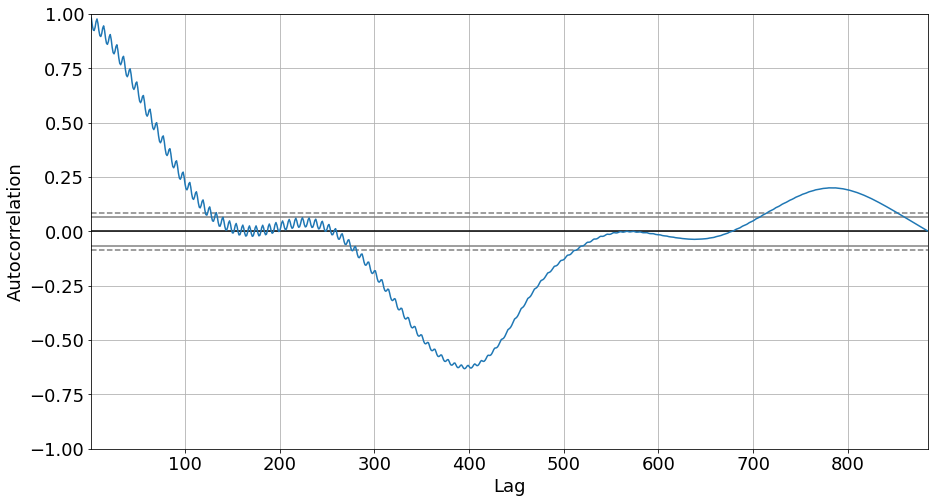

In [15]:
autocorrelation_plot(cruzada)

In [16]:
df = pd.DataFrame()

In [17]:
df['ds'] = dados_sp['datahora']

In [18]:
df['y'] = dados_sp['casos_novos']

In [19]:
modelo = Prophet()

In [20]:
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [21]:
dataframefuturo = modelo.make_future_dataframe(periods=30)

In [22]:
dataframefuturo.head()

,ds
0,2020-02-25
1,2020-02-26
2,2020-02-27
3,2020-02-28
4,2020-02-29


In [23]:
previsao = modelo.predict(dataframefuturo)

In [24]:
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-02-25,-114.303728,-794.040253,1582.376584,-114.303728,-114.303728,500.316952,500.316952,500.316952,500.316952,500.316952,500.316952,0.0,0.0,0.0,386.013224
1,2020-02-26,-96.932780,-719.711184,1722.003055,-96.932780,-96.932780,554.767711,554.767711,554.767711,554.767711,554.767711,554.767711,0.0,0.0,0.0,457.834930
2,2020-02-27,-79.561833,-596.245520,1825.492297,-79.561833,-79.561833,650.710000,650.710000,650.710000,650.710000,650.710000,650.710000,0.0,0.0,0.0,571.148167
3,2020-02-28,-62.190885,-880.311741,1444.057681,-62.190885,-62.190885,368.442066,368.442066,368.442066,368.442066,368.442066,368.442066,0.0,0.0,0.0,306.251181
4,2020-02-29,-44.819937,-1224.618934,1119.612473,-44.819937,-44.819937,30.824737,30.824737,30.824737,30.824737,30.824737,30.824737,0.0,0.0,0.0,-13.995200


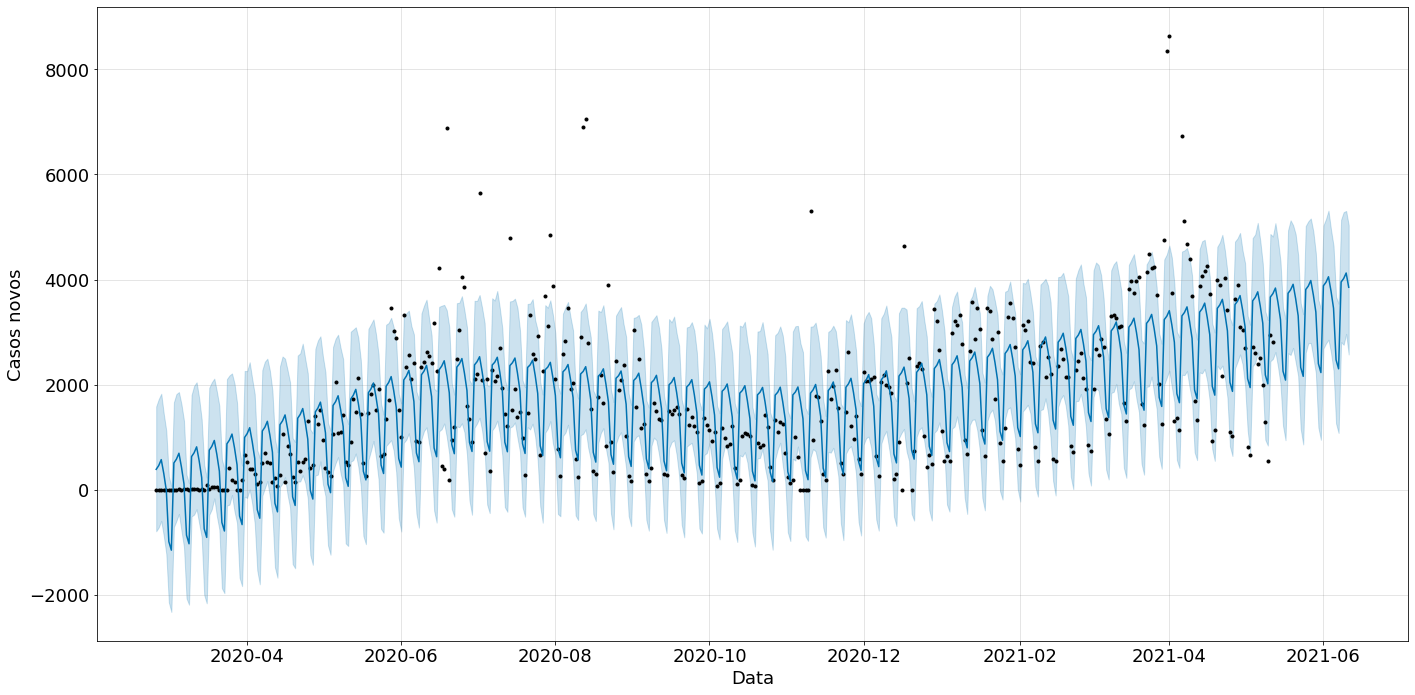

In [25]:
modelo.plot(previsao,xlabel='Data',ylabel='Casos novos',figsize=(20,10));

In [26]:
df = pd.DataFrame()

In [27]:
df['ds'] = dados_sp['datahora'][:400]

In [28]:
df['y'] = dados_sp['casos_novos'][:400]

In [29]:
modelo = Prophet()

In [30]:
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
dataframefuturo = modelo.make_future_dataframe(periods=43)

In [32]:
previsao = modelo.predict(dataframefuturo)

In [33]:
df_teste = pd.DataFrame()
df_teste['ds'] = dados_sp['datahora'][400:]
df_teste['y'] = dados_sp['casos_novos'][400:]

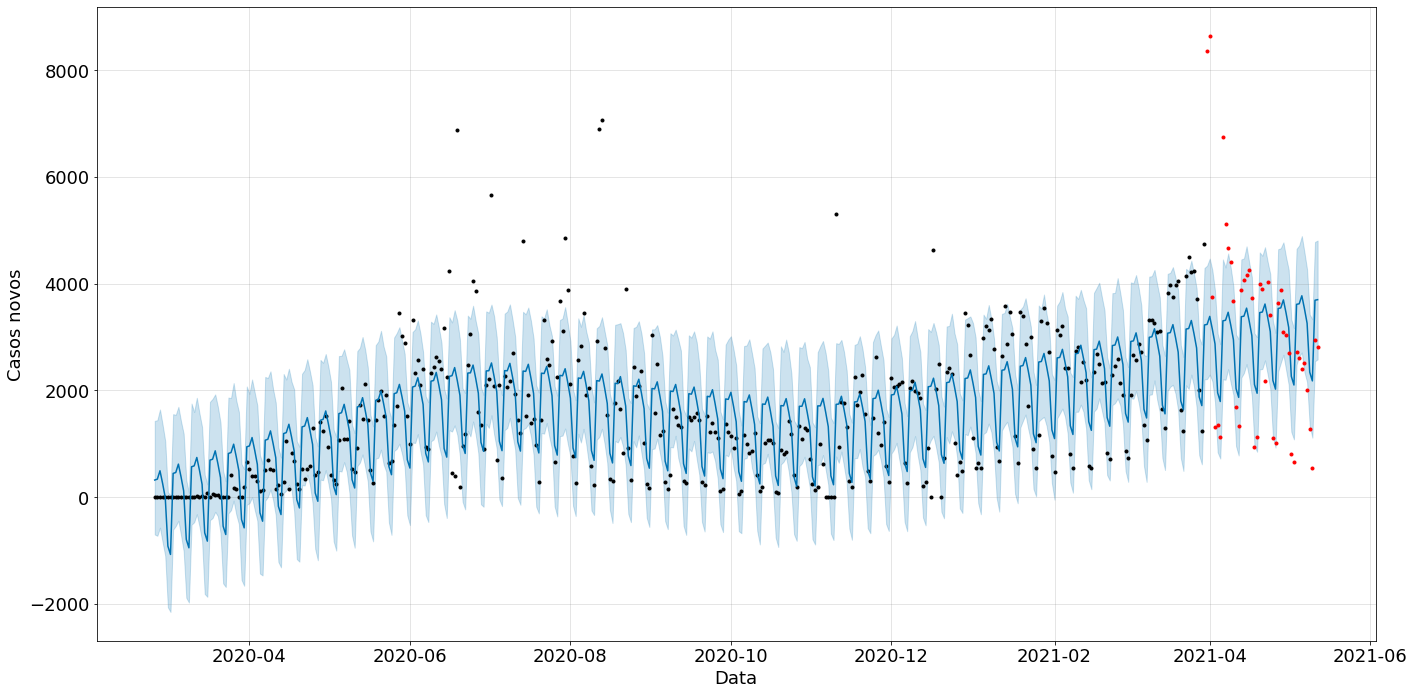

In [34]:
modelo.plot(previsao,xlabel='Data',ylabel='Casos novos',figsize=(20,10));
plt.plot(df_teste['ds'], df_teste['y'], '.r')

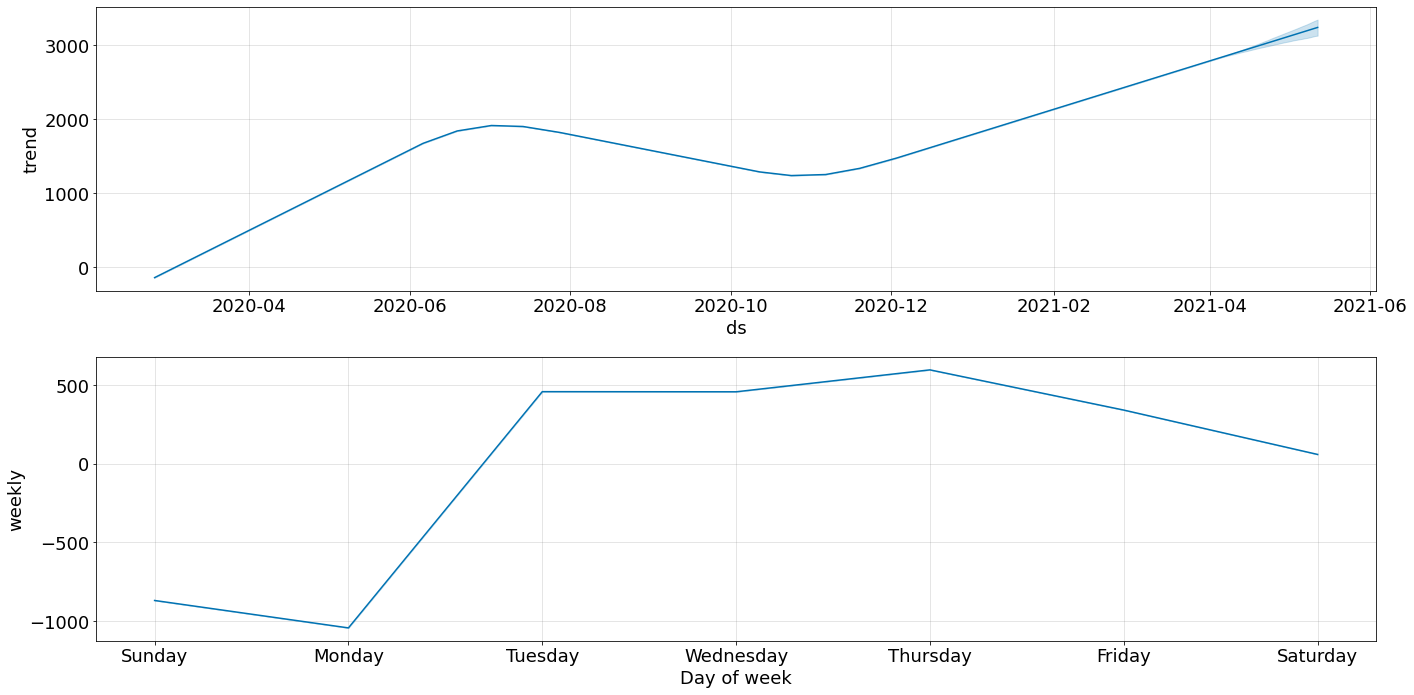

In [35]:
modelo.plot_components(previsao, figsize=(20,10));

In [36]:
def previsao_dias(dias : int):
  dias_para_prever = dias
  periodo_em_dias = len(dados_sp) - dias_para_prever

  df_casos_acumulados = pd.DataFrame()
  df_casos_acumulados['ds'] = dados_sp['datahora'][:periodo_em_dias]
  df_casos_acumulados['y'] = dados_sp['casos'][:periodo_em_dias]
  modelo_casos_acumulados = Prophet()


  modelo_casos_acumulados.fit(df_casos_acumulados)
  dataframefuturo_casos_acumulados = modelo_casos_acumulados.make_future_dataframe(periods=dias_para_prever)
  previsao_casos_acumulados = modelo_casos_acumulados.predict(dataframefuturo_casos_acumulados)

  df_teste_casos_acumulados = pd.DataFrame()
  df_teste_casos_acumulados['ds'] = dados_sp['datahora'][periodo_em_dias:]
  df_teste_casos_acumulados['y'] = dados_sp['casos'][periodo_em_dias:]

  titulo = str(periodo_em_dias) + " dias de teste | " + str(dias_para_prever) + " dias de previsão"


  modelo_casos_acumulados.plot(previsao_casos_acumulados,xlabel='Data',ylabel='Total absoluto de casos', figsize=(20,10));
  plt.title(titulo)
  plt.plot(df_teste_casos_acumulados['ds'], df_teste_casos_acumulados['y'], '.r')

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

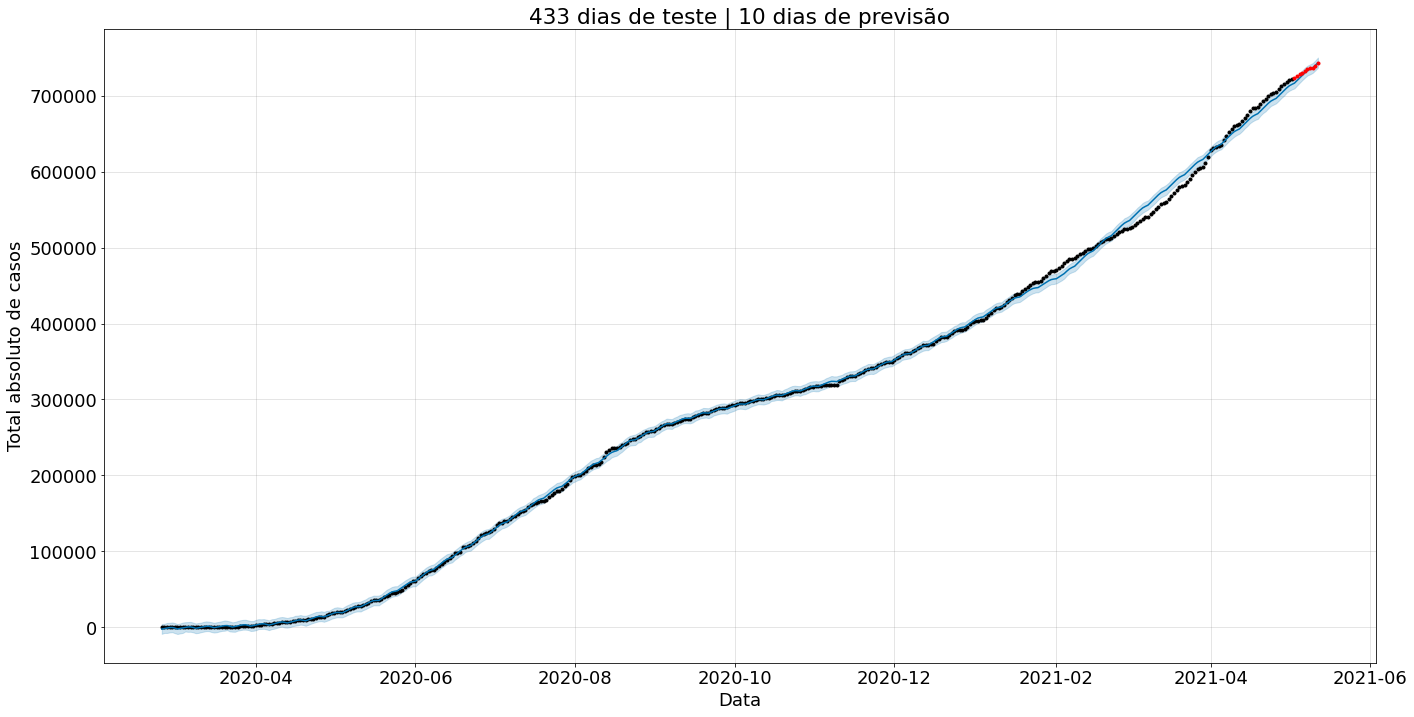

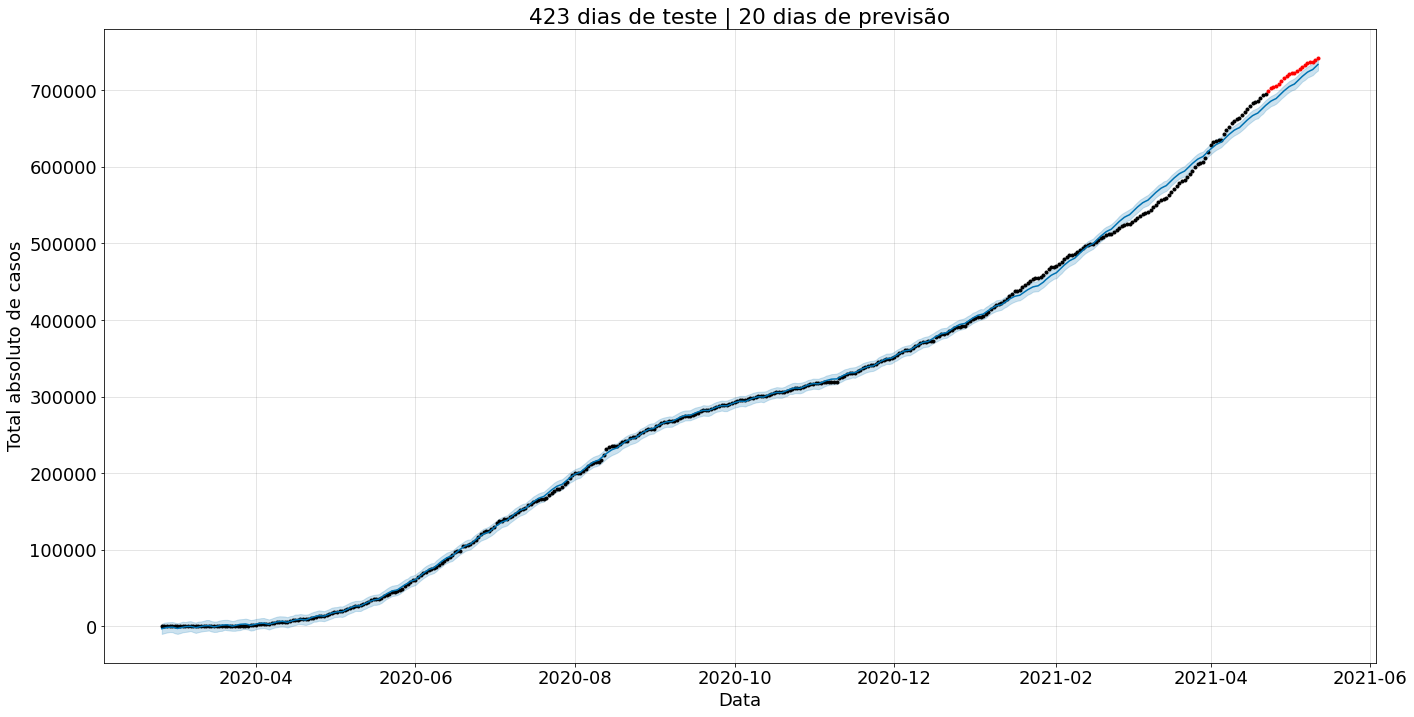

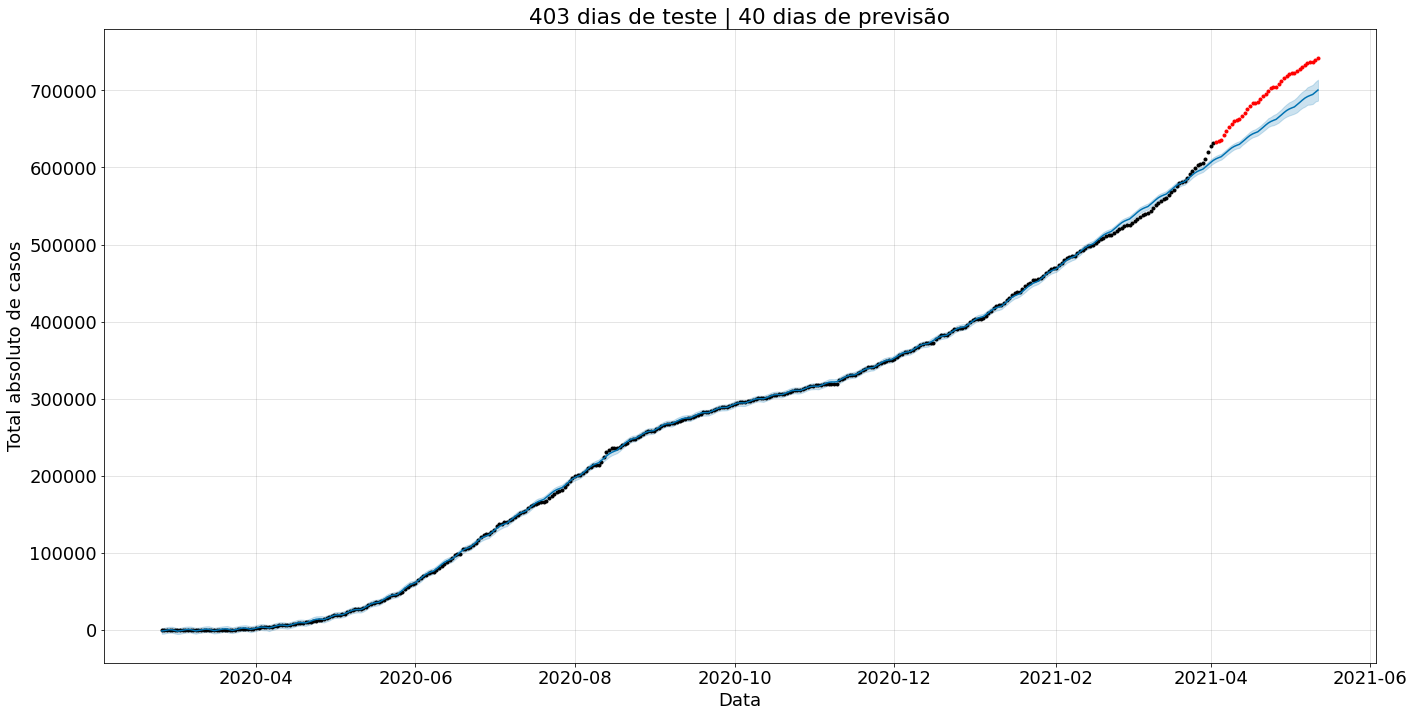

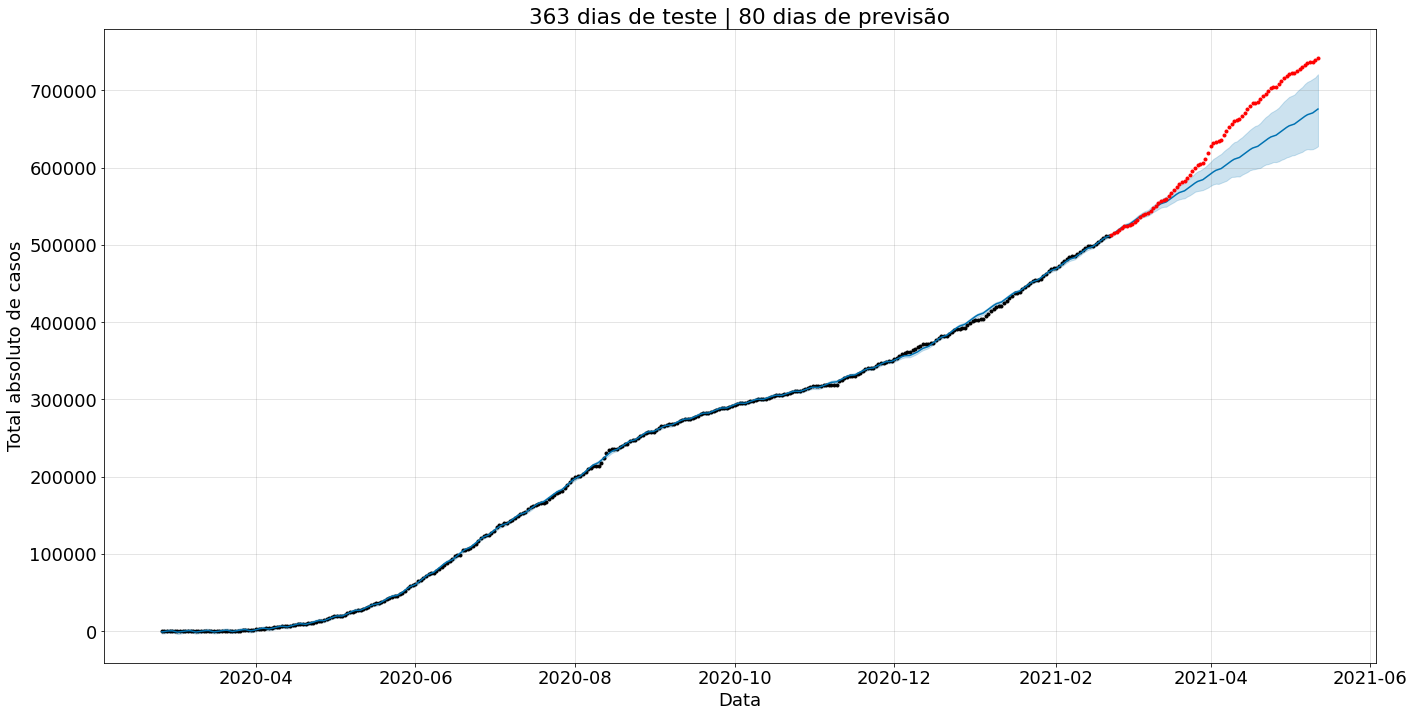

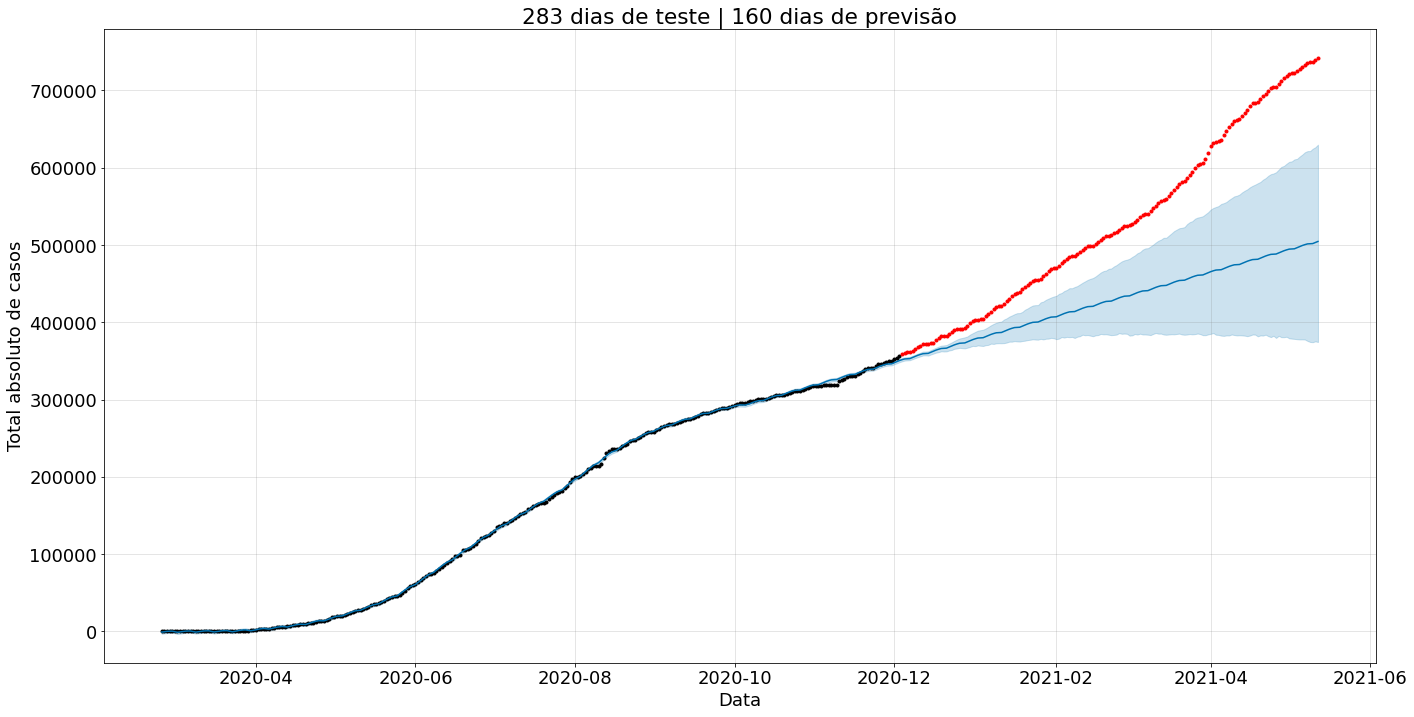

In [37]:
previsao_dias(10)
previsao_dias(20)
previsao_dias(40)
previsao_dias(80)
previsao_dias(160)

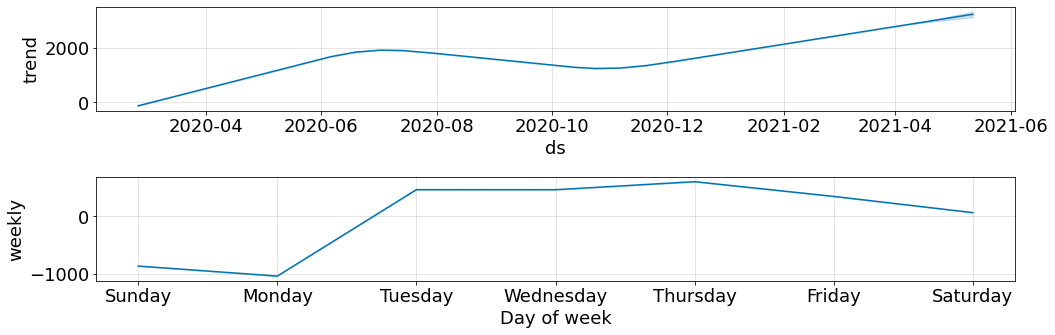

In [38]:
modelo.plot_components(previsao,figsize=(15,5));

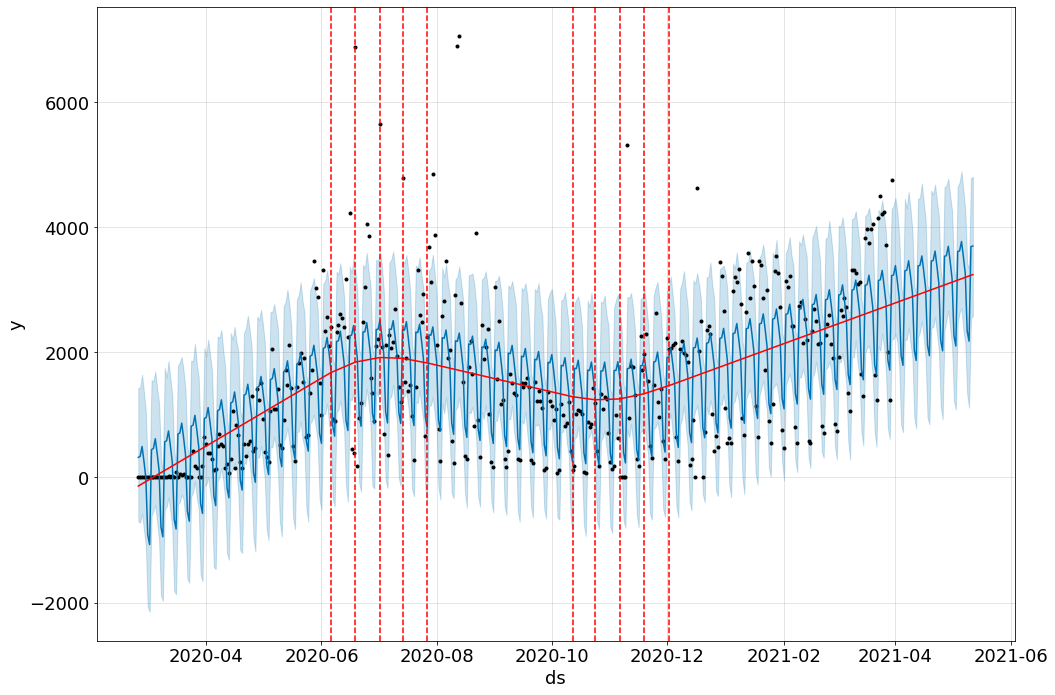

In [39]:
fig = modelo.plot(previsao, figsize=(15,10))
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

In [40]:
modelo = Prophet(n_changepoints=25, changepoint_prior_scale=10.0)

In [41]:
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [42]:
dataframefuturo = modelo.make_future_dataframe(periods=43)

In [43]:
previsao = modelo.predict(dataframefuturo)

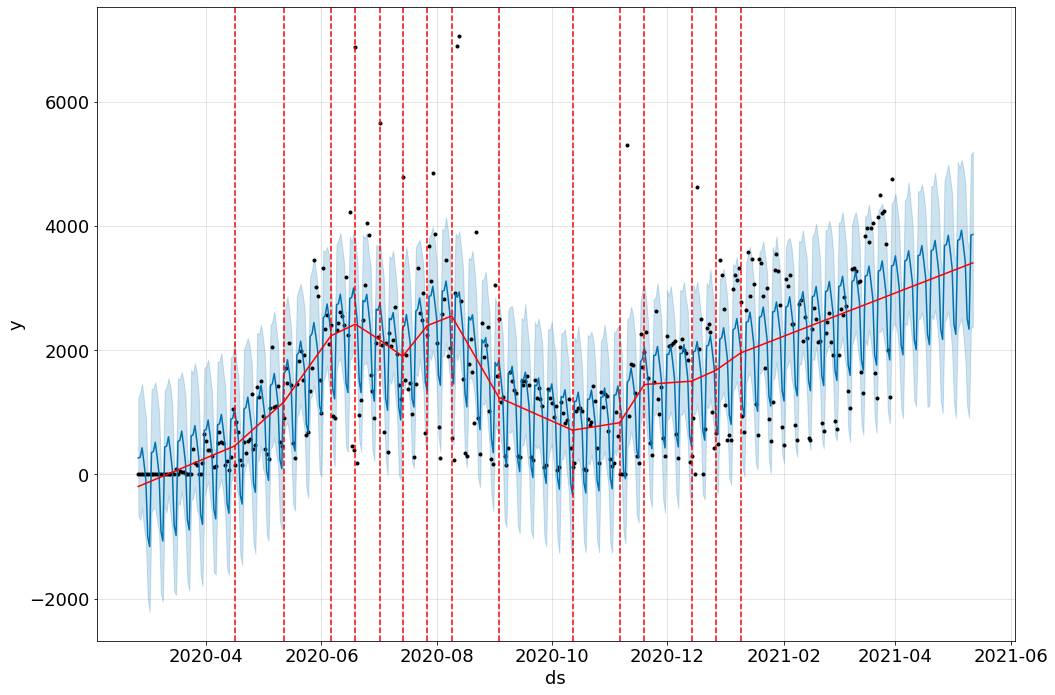

In [44]:
fig = modelo.plot(previsao, figsize=(15,10))
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

In [45]:
def plotar_grafico_com_changepoint(changepoint_prior_scale_input=0.05, periods_input=43, n_changepoints_input=25):
  modelo = Prophet(n_changepoints=n_changepoints_input, changepoint_prior_scale=changepoint_prior_scale_input)
  modelo.fit(df)
  dataframefuturo = modelo.make_future_dataframe(periods=periods_input)
  previsao = modelo.predict(dataframefuturo)
  fig = modelo.plot(previsao, figsize=(15,10))
  a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

def plotar_grafico_com_changepoint_na_mao(periods_input=43, points = ['2020-12-31']):
  modelo = Prophet(changepoints=points)
  modelo.fit(df)
  dataframefuturo = modelo.make_future_dataframe(periods=periods_input)
  previsao = modelo.predict(dataframefuturo)
  fig = modelo.plot(previsao, figsize=(15,10))
  a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


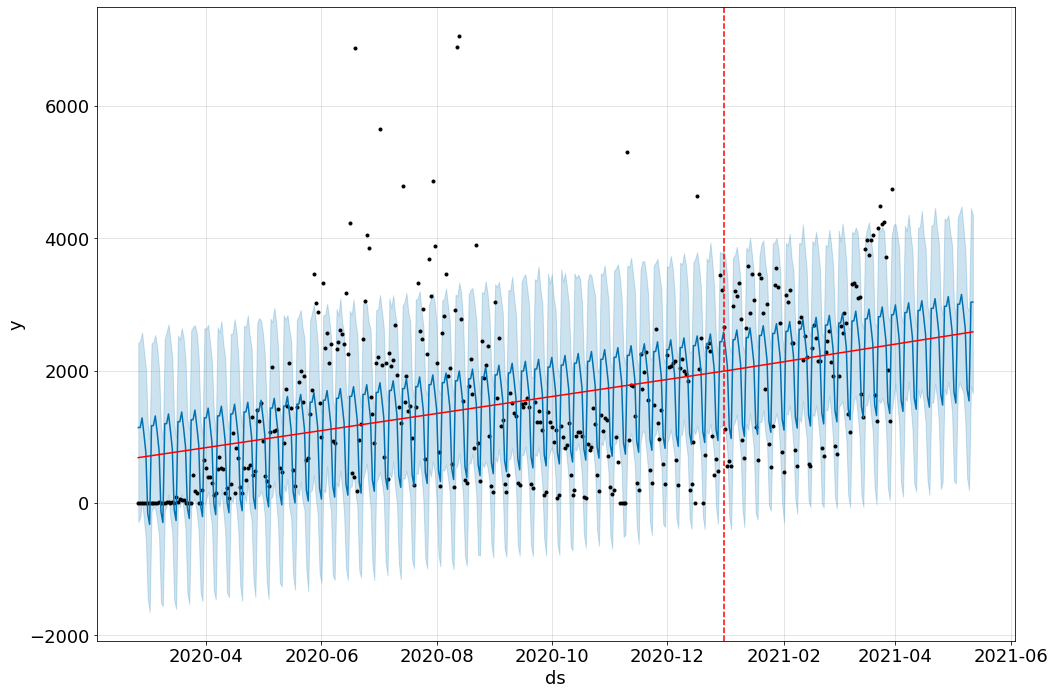

In [46]:
plotar_grafico_com_changepoint_na_mao()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


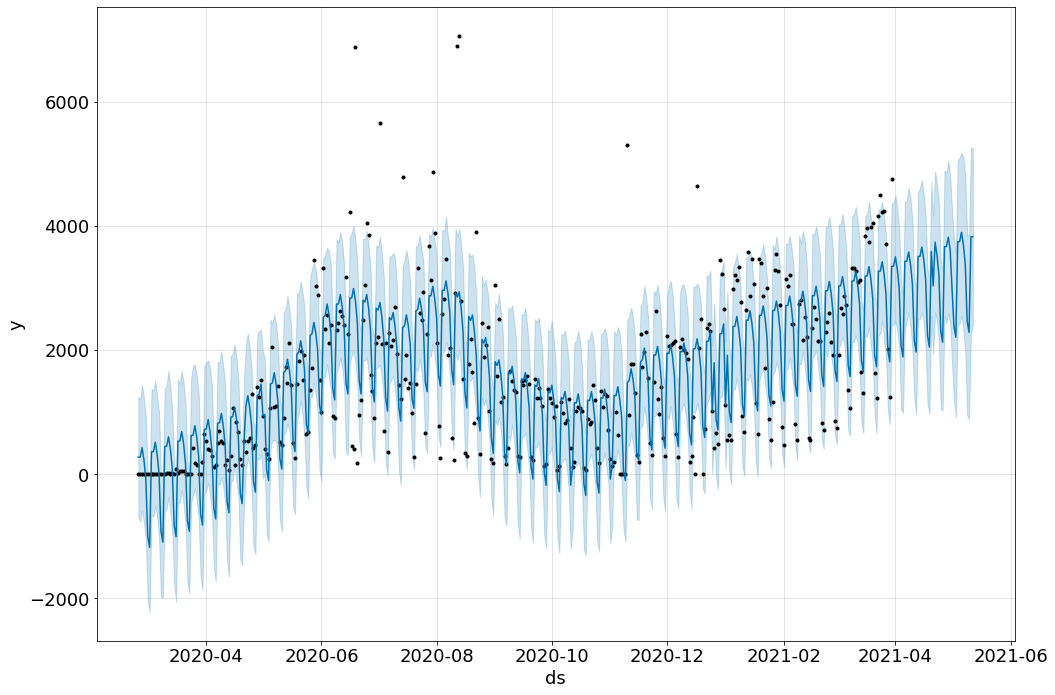

In [50]:
modelo = Prophet(changepoint_prior_scale=10)
modelo.add_country_holidays(country_name='BR')
modelo.fit(df)
dataframefuturo = modelo.make_future_dataframe(periods=43)
previsao = modelo.predict(dataframefuturo)
fig = modelo.plot(previsao, figsize=(15,10))
#a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

In [51]:
#Usando feriados especificos do municipio de SP

feriados_sp_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-09-07',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-12-25'
]

feriados_sp_2021 = [
'2021-01-01',
'2021-01-25',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01'
]


feriados_sp_2020 = pd.DataFrame({
  'holiday': 'sp_2020',
  'ds': pd.to_datetime(feriados_sp_2020)
})

feriados_sp_2021 = pd.DataFrame({
  'holiday': 'sp_2021',
  'ds': pd.to_datetime(feriados_sp_2021)
})

feriados = pd.concat((feriados_sp_2020, feriados_sp_2021))

In [60]:
# Usando os feriados do município de SP


modelo_feriados = Prophet(n_changepoints = 25, changepoint_prior_scale=10.0, holidays=feriados, seasonality_mode='multiplicative')
modelo_feriados.fit(df)
dataframefuturo = modelo_feriados.make_future_dataframe(periods=36)
previsao = modelo_feriados.predict(dataframefuturo)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [61]:
previsao.head()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,holidays,holidays_lower,holidays_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,sp_2020,sp_2020_lower,sp_2020_upper,sp_2021,sp_2021_lower,sp_2021_upper,weekly,weekly_lower,weekly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2020-02-25,-39.885854,-937.638266,813.071152,-39.885854,-39.885854,-0.223254,-0.223254,-0.223254,0.045415,0.045415,0.045415,-0.223254,-0.223254,-0.223254,0.0,0.0,0.0,0.268669,0.268669,0.268669,0.0,0.0,0.0,-41.697274
1,2020-02-26,-35.665142,-1041.815397,905.918518,-35.665142,-35.665142,-0.223254,-0.223254,-0.223254,0.070254,0.070254,0.070254,-0.223254,-0.223254,-0.223254,0.0,0.0,0.0,0.293508,0.293508,0.293508,0.0,0.0,0.0,-38.170769
2,2020-02-27,-31.444429,-983.599053,810.275722,-31.444429,-31.444429,0.000000,0.000000,0.000000,0.401782,0.401782,0.401782,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.401782,0.401782,0.401782,0.0,0.0,0.0,-44.078238
3,2020-02-28,-27.223716,-1075.544194,913.639556,-27.223716,-27.223716,0.000000,0.000000,0.000000,0.223328,0.223328,0.223328,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.223328,0.223328,0.223328,0.0,0.0,0.0,-33.303547
4,2020-02-29,-23.003004,-942.600818,932.428433,-23.003004,-23.003004,0.000000,0.000000,0.000000,0.019241,0.019241,0.019241,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.019241,0.019241,0.019241,0.0,0.0,0.0,-23.445599


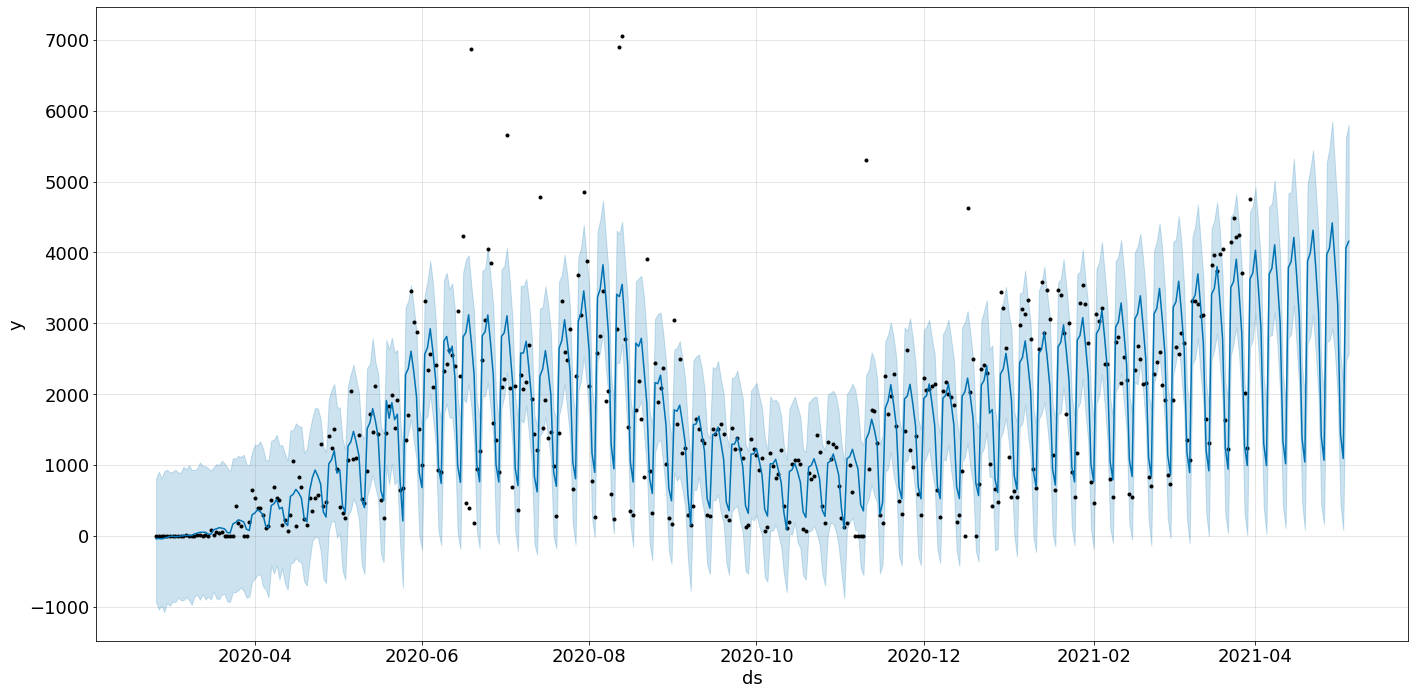

In [62]:
fig = modelo_feriados.plot(previsao, figsize=(20,10));


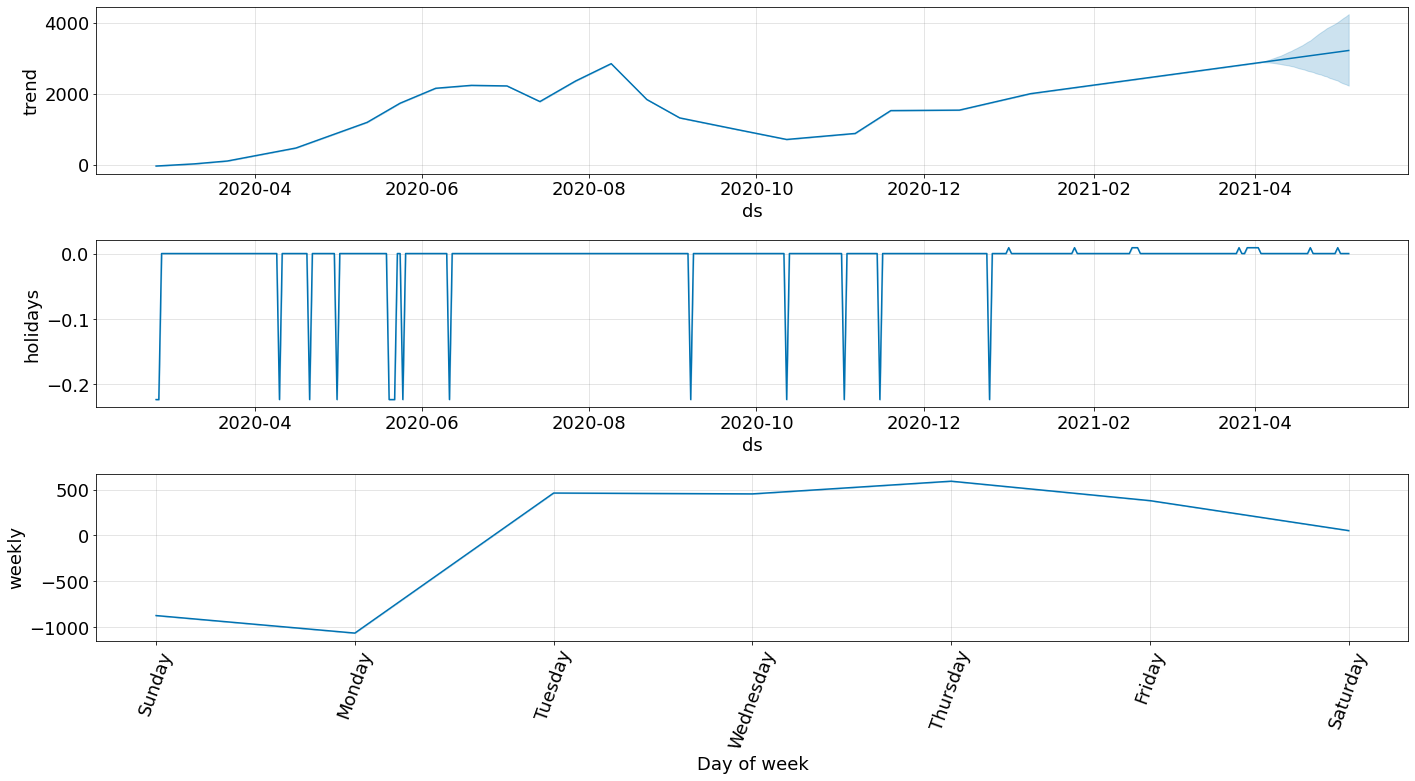

In [63]:
modelo.plot_components(previsao, figsize=(20,10))
plt.xticks(rotation='70'); #olhar rotação

In [59]:
mean_absolute_error(df['y'], previsao['yhat'][:400])

536.6084252994144

In [65]:
mean_absolute_error(df['y'], previsao['yhat'][:400])

452.3618279357078